In [49]:
scriptdirectory = r"C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Tübingen_Branch"

output_directory = r"D:\MEA_DATA_Aachen\ANALYZED\ID046_lfp_spikes\analysis_trial"
filename = "2021-05-17_cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1"

temp_dir = r"D:\MEA_DATA_Aachen\ANALYZED\ID046_lfp_spikes\2021-05-17_cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1_from_0_to_120_analyzed_on_21102021"

In [11]:
import os
os.chdir(scriptdirectory)

In [17]:
import sys
import numpy as np
import pandas as pd
import importlib

import McsPy
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.signal import butter, lfilter, freqz, find_peaks, correlate, gaussian, filtfilt
from scipy import stats
from scipy import signal

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from Butterworth_Filter import butter_bandpass, butter_bandpass_filter

import glob
from plot_signal_and_spikes import plot_signal_and_spikes_from_bandpassfilteredsignal
import time

from neo.core import AnalogSignal
import quantities as pq

from elephant.spectral import welch_psd
from elephant.current_source_density import estimate_csd
import pickle

%matplotlib notebook

In [18]:
os.chdir(output_directory)

In [23]:
MAIN_RECORDING_DICTIONARY = pickle.load(open(os.path.join(output_directory+'\\MAIN_RECORDING_Dictionary_'+filename+'.pkl'), "rb"))

In [24]:
MAIN_RECORDING_DICTIONARY.keys()

dict_keys(['spikedic_MAD', 'network_bursts_seconds', 'fr_dic', 'isi_dictionary', 'isi_average_dic', 'isi_std_dic', 'Infos_Recording', 'Infos_Analysis', 'Infos_Anatomy', 'Basics', 'Bursts', 'Interburst-Intervals', 'bursting_time_per_channel', 'bursts_per_channel', 'GRAPH_shared_bursts', 'burst_connections'])

In [25]:
network_bursts_seconds = MAIN_RECORDING_DICTIONARY['network_bursts_seconds']
spikedic_MAD = MAIN_RECORDING_DICTIONARY['spikedic_MAD']
fr_dic = MAIN_RECORDING_DICTIONARY['fr_dic']
isi_dictionary = MAIN_RECORDING_DICTIONARY['isi_dictionary']
isi_average_dic = MAIN_RECORDING_DICTIONARY['isi_average_dic']
Infos_Recording = MAIN_RECORDING_DICTIONARY['Infos_Recording']
Infos_Analysis = MAIN_RECORDING_DICTIONARY['Infos_Analysis']
Infos_Anatomy = MAIN_RECORDING_DICTIONARY['Infos_Anatomy']
Bursts = MAIN_RECORDING_DICTIONARY['Bursts']
Interburst_Intervals = MAIN_RECORDING_DICTIONARY['Interburst-Intervals']
bursting_time_per_channel = MAIN_RECORDING_DICTIONARY['bursting_time_per_channel']
bursts_per_channel = MAIN_RECORDING_DICTIONARY['bursts_per_channel']
burst_connections = MAIN_RECORDING_DICTIONARY['burst_connections']
Basics = MAIN_RECORDING_DICTIONARY['Basics']
inverted_layerdic = Infos_Anatomy['layerdic_invert']
layerdic = Infos_Anatomy['layerdic']
tick = 40
scale_factor_for_second = 1e-06

In [26]:
Infos_Recording


{'medium': 'aCSF',
 'info_dics_subrecordings': {'0_to_120': {'tick': 40,
   'timelengthrecording_s': 120.39999999999999,
   'timelengthrecording_ms': 120400000,
   'first_recording_timepoint': 0,
   'scale_factor_for_second': 1e-06,
   'time_in_sec': array([0.0000000e+00, 4.0000000e-05, 8.0000000e-05, ..., 1.1999992e+02,
          1.1999996e+02, 1.2000000e+02]),
   'sampling_frequency': 25000}},
 'recordings_date': '2021-05-07',
 'timelengthrecording_s': 120.39999999999999,
 'scale_factor_for_second': 1e-06,
 'tick': 40}

In [27]:
os.chdir(inputdirectory)

NameError: name 'inputdirectory' is not defined

### Import of all Custom Functions

In [28]:

def get_channel_infos(filedirectory, meafile):
    channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirectory, 
                                                          meafile))
    print(channel_raw_data.recordings)
    print(channel_raw_data.comment)
    print(channel_raw_data.date)
    print(channel_raw_data.clr_date)
    print(channel_raw_data.date_in_clr_ticks)
    print(channel_raw_data.file_guid)
    print(channel_raw_data.mea_name)
    print(channel_raw_data.mea_sn)
    print(channel_raw_data.mea_layout)
    print(channel_raw_data.program_name)
    print(channel_raw_data.program_version)
    analognumber = len(channel_raw_data.recordings[0].analog_streams.keys())
    print('In total '+ str(analognumber) 
          + " analog_streams were identified.\n")
    for i in range(len(channel_raw_data.recordings[0].analog_streams.keys())):
        keylist = []
        stream = channel_raw_data.recordings[0].analog_streams[i]
        for key in stream.channel_infos.keys():
                keylist.append(key)
        channel_id = keylist[0]
        datapoints = channel_raw_data.recordings[0].analog_streams[i].channel_data.shape[1]
        samplingfrequency = stream.channel_infos[channel_id].sampling_frequency
        ticks = stream.channel_infos[channel_id].info['Tick']
        time = stream.get_channel_sample_timestamps(channel_id)
        scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
        time_in_sec = time[0] * scale_factor_for_second
        timelengthrecording_ms = time[0][-1]+ticks
        timelengthrecording_s = (time[0][-1]+ticks)*scale_factor_for_second
        print("analog_stream Nr. " + str(i) + ": ")
        print("datapoints measured = " + str(datapoints))
        print("sampling frequency = " + str(samplingfrequency))
        print("ticks = " + str(ticks))
        print("total recordingtime is: " 
              + str(timelengthrecording_s) + "seconds \n")




def get_MEA_Signal(analog_stream, channel_idx, from_in_s=0, to_in_s=None):
    '''
    Extracts one Channels (channel_idx) Sginal 
    
    :param analog_stream = the analogstream from one recording
    :param channel_idx   = the channel index of the channel where you 
                            extract the values from
    :param from_in_s     = starting point of the range you want to observe 
                            in seconds
    :param to_in_s       = ending point of the range you want to observe. 
                            Default is None (i.e. whole range)
    
    Returns: the signal in uV, time stamps in sec, the sampling frequency
    
    
    '''
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude

    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(
            analog_stream.channel_data.shape[1], 
            int(to_in_s * sampling_frequency)
            )

    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(
        channel_id, from_idx, to_idx
        )

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second

    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV
    
    return signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second


def get_MEA_Channel_labels(np_analog_for_filter):
    '''
    Gives a List of all MEA Channel Labels (e.g. R12) in the order they appear
    within the recording.
    
    :param analogstream_data = an numpy array shape(channels, data)
    
    '''
    labellist = []
    for i in range(0, len(np_analog_for_filter)):
        #channel_idx = i
        ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]
        channel_id = ids[i]
        channel_info = analog_stream_0.channel_infos[channel_id]
        #print(channel_info.info['Label'])
        labellist.append(channel_info.info['Label'])
    return labellist
    

def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return 
    them as an array

    The signal transitions from a sample above the threshold to a sample 
    below the threshold for a detection and
    the last detection has to be more than dead_time apart 
    from the current one.

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff(
        (signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(
        np.diff(threshold_crossings) >= dead_time_idx, 0, True
        )
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(
            np.diff(threshold_crossings) >= dead_time_idx, 0, True
            )
    return threshold_crossings


def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx


def align_to_minimum(signal, fs, threshold_crossings, search_range, first_time_stamp=0):
    """
    Returns the index of the next negative spike peak for all threshold crossings

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal 
                                crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the 
                         minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)


def find_triggers(dset_trigger, tick):
    
    for i in range(0,len(dset_trigger)-1):
        trigger_n=i
        Trigger_An=dset_trigger[trigger_n]
        diff_An=np.diff(Trigger_An)
        peaks, _ = find_peaks(diff_An, height = 2000) #MEA60=0.75
        peaks_off, _ = find_peaks(-diff_An, height = 2000) #""
        if len(peaks)>=0:
            break
    
    if trigger_n ==0:
        odd_peaks= peaks
        odd_peaks_off= peaks_off
    else:
        odd_peaks=peaks
        odd_peaks_off=peaks_off
    #x=np.arange(len(Trigger_An))*tick
    #plt.plot(x, Trigger_An)
    return odd_peaks, odd_peaks_off, diff_An

def spike_on_off(trigger_on, trigger_off, spikedic, tick):
    """
    Takes the dictionary with all spikes and sorts them into either a dictionary for
    spikes while trigger on (=ONdic) or off (=OFFdic)
    
    :param trigger_on =basically created through the find_triggers function 
                        and marks points were stimulation is turned on
    :param trigger_off =see trigger_on but for stimulation off
    :spikedic = dictionary of spikes for each electrode
    :tick
    """
    on=[]
    off=[]
    ONdic ={}
    OFFdic={}
    Trigger_An=[]
    Trigger_Aus=[]
    
    if len(trigger_off)==0:
        Trigger_An=[]
    elif trigger_off[len(trigger_off)-1]>trigger_on[len(trigger_on)-1]:
        Trigger_An=trigger_on*tick
    else:
        Trigger_An=[]
        for n in range(0,len(trigger_on)-1):
            Trigger_An.append(trigger_on[n]*tick)   
        Trigger_An=np.array(Trigger_An)

            
    if len(trigger_on)==0:
        Trigger_Aus=[]
    elif trigger_off[0]>trigger_on[0]:
        Trigger_Aus=trigger_off*tick
    else:
        Trigger_Aus=[]
        for n in range(1,len(trigger_off)):
            Trigger_Aus.append(trigger_off[n]*tick)
        Trigger_Aus=np.array(Trigger_Aus)
    
    Trigger_Aus2=np.insert(Trigger_Aus,0,0)
    
    for key in spikedic:
        ON = []
        OFF = []
        for i in spikedic[key]: #i mit 40 multiplizieren, da Trigger an und aus mit Tick multipliziert sind
            if len(Trigger_An)==0:
                OFF.append(i)
            if any(Trigger_An[foo] < i*tick < Trigger_Aus[foo]  for foo in np.arange(len(Trigger_Aus)-1)):
                ON.append(i)
            elif any(Trigger_Aus2[foo]  < i*tick < Trigger_An[foo]  for foo in np.arange(len(Trigger_An))):
                OFF.append(i)
        ONdic[key]=np.asarray(ON)
        OFFdic[key]=np.asarray(OFF)
    
    return ONdic, OFFdic


def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[int((index-pre_idx)):int((index+post_idx))]
            cutouts.append(cutout)
    if len(cutouts)>0:
        return np.stack(cutouts)
    
    
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts

    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))

    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')

    if show:
        plt.show()

        
def butter_lowpass_filter(data, cutoff, fs, order):

    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



def subdivide_spiketrain(spiketrain, sub_start = 0, sub_stop = 10, tick=40, scale_factor_for_second=1e-06):
    '''
    Excpects: 
        a spiketrain with tick datapoints
        default ticks are 40
        default scale_factor_for_seconds = 1e-06
        provide the start and stop of the desired sub in seconds
    
    Does:
        converts the desired seconds into data ticks
        checks if the spikes of the given spiketrain is in the desired subs
        substracts the starting time -->
        
    Returns:
        a spiketrain dictionary that again starts from zero
    
    '''
    sub_start_tick = sub_start / (tick*scale_factor_for_second)
    sub_stop_tick = sub_stop / (tick*scale_factor_for_second)
    sub_spiketrain = {}
  
    for key in spiketrain: 
        list_per_key = []
        for i in spiketrain[key]:
            if (i>=sub_start_tick ) & (i<sub_stop_tick):
                list_per_key.append(int(i-sub_start_tick))
        sub_spiketrain[key]=list_per_key

    return sub_spiketrain

### Find channels that are bursting during network bursts


In [30]:
Bursts['R12'] #µseconds

[]

In [16]:
spikedic_MAD['R12'][-1] #ticks

17994387

In [17]:
network_bursts_seconds[-1] #seconds

(1790.8, 1794.04)

In [31]:
tick = 40

In [32]:
length = []

for i in network_bursts_seconds:
    diff = i[1] - i[0]
    length.append(diff)

In [33]:
np.max(length)

3.173385496677753

In [34]:
len(network_bursts_seconds)

29

In [35]:
np.mean(length), np.std(length), np.median(length)

(1.9395740186733876, 0.42798656792412326, 1.9258142873754167)

We want to find every channel that does burst during a network burst. Further, we need for every network burst the amount of active channels (via Spikedic_MAD). The LFP will be extracted in a later step. For this, we will need the raw data.

In [36]:
def find_network_burst_components(network_bursts_seconds, Bursts, spikedic_MAD):
    
    '''
    ______________________
    parameters
    
    network_bursts_seconds : list of tuples
        tuples are all filtered network bursts (i.e., the gaussian smoothed firing rate that
        crosses the mean of the smoothed firing rate)
        
        tuple(a, b) with a = burststart, b = burststop in seconds
        
    
    Bursts : dict
        key = channellabel
        value = list of tuples (a, b) with a = burststart, b = burststop in µseconds
        
    spikedic_MAD : dict
    
        key = channellabel
        value = list of spikes in ticks --> times tick and scale_factor_second_to_receive
            the spikes in seconds
            
    _______________________
    returns
        
    network_bursts_dictionary : dict
        key = tuple (a, b) with a = networkburststart, b = networkburststop in seconds
        
        value = tuple (a,b,c) with a=the number of single channel bursting channels,
                b = the number of active (i.e., spiking) channels, and c = array of all 
                single channel bursting channels
                
    relevant_relevant_channels : list
    
        list with all channels that are active at any network burst
        can be used to filter the original signal when extracting the LFP
    
    
    '''





    network_bursts_dictionary = {}

    # relevant channels is basically all channels that burst at any time in one list
    relevant_channels = []

    for i in network_bursts_seconds:
        network_key = str(i)
        burst_list = []


        bursting_channels = []
        active_channels = []
        for key in Bursts:
            for b in Bursts[key]:
                # if either start or end of single channel burst is within the network burst
                burst_start = b[0]*1e-06
                burst_stop = b[1]*1e-06

                if (i[0] <= burst_start <= i[1]) or (i[0] <= burst_stop <= i[1]):
                    bursting_channels.append(key)
                    relevant_channels.append(key)
                    break

        for key in spikedic_MAD:
            for s in spikedic_MAD[key]:
                s = s*tick*1e-06
                if (i[0] <= s <= i[1]):
                    active_channels.append(key)
                    break




        bursting_channels = np.unique(bursting_channels)
        n_bursting_channels = len(bursting_channels)
        active_channels = np.unique(active_channels)
        n_active_channels = len(active_channels)

        network_bursts_dictionary[network_key] = (
            n_bursting_channels, n_active_channels, bursting_channels, active_channels
            )
    
    return network_bursts_dictionary, relevant_channels
        
    

In [37]:
network_bursts_dictionary, relevant_channels = find_network_burst_components(
                                                network_bursts_seconds, Bursts, spikedic_MAD)

In [38]:
network_bursts_dictionary

{'(0.7632, 1.7830399568106312)': (6,
  16,
  array(['H3', 'J2', 'J3', 'K2', 'L1', 'L2'], dtype='<U2'),
  array(['C2', 'E3', 'F2', 'F3', 'G1', 'G2', 'H1', 'H2', 'H3', 'J2', 'J3',
         'K2', 'K3', 'K4', 'L1', 'L2'], dtype='<U2')),
 '(4.198971504983389, 5.520802905315615)': (3,
  16,
  array(['J2', 'K2', 'L2'], dtype='<U2'),
  array(['E3', 'F2', 'F3', 'G1', 'G2', 'H1', 'H2', 'H3', 'J1', 'J2', 'J3',
         'K1', 'K2', 'K3', 'L1', 'L2'], dtype='<U2')),
 '(7.510976024916944, 9.134798868770764)': (4,
  11,
  array(['H2', 'J2', 'K2', 'L2'], dtype='<U2'),
  array(['F2', 'G2', 'H1', 'H2', 'H3', 'J2', 'K2', 'K3', 'L1', 'L2', 'M1'],
        dtype='<U2')),
 '(11.694300119601328, 13.664670521594685)': (4,
  16,
  array(['H3', 'K2', 'L1', 'L2'], dtype='<U2'),
  array(['F2', 'F3', 'G2', 'G3', 'H1', 'H2', 'H3', 'J1', 'J2', 'K2', 'K3',
         'K4', 'L1', 'L2', 'M1', 'M2'], dtype='<U2')),
 '(16.12020750498339, 18.02621907475083)': (5,
  12,
  array(['H2', 'H3', 'J2', 'K2', 'L2'], dtype='<U2'),
  

In [39]:
network_bursts_seconds

[(0.7632, 1.7830399568106312),
 (4.198971504983389, 5.520802905315615),
 (7.510976024916944, 9.134798868770764),
 (11.694300119601328, 13.664670521594685),
 (16.12020750498339, 18.02621907475083),
 (19.486669498338873, 21.437237182724253),
 (23.249185843853823, 25.160148093023256),
 (26.87308316611296, 28.784045415282392),
 (31.393053460132894, 33.28916367109635),
 (36.24966995348837, 37.63487377408637),
 (37.734873774086374, 39.591378549833884),
 (42.190485235880395, 44.18560903488372),
 (46.824321156146176, 48.75013544352159),
 (51.03239864784053, 53.00276904983389),
 (55.418700598006644, 57.05737548006645),
 (58.81981734717608, 60.71592755813953),
 (61.562493735880395, 64.73587923255815),
 (68.08748918770765, 69.82022697840532),
 (72.03813135049833, 73.98374835548172),
 (75.47390285548173, 78.27103671760797),
 (80.8651927242525, 82.4246567358804),
 (88.6823155, 91.49430140033223),
 (94.13796420099668, 96.10338392358804),
 (98.40544984551495, 100.84613479069768),
 (103.85614786710964

In [55]:
filename= '2021-05-17T11-28-41__cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1'

In [61]:
filebase = filename.split('__')[1]

In [136]:
lowpassfile = glob.glob('*lowpass*.npy')[0]
bandpassfile = glob.glob('*bandpass*.npy')[0]

lfp_down_file = glob.glob('*LFP_DOWNS*.npy')[0]
lfp_up_file = glob.glob('*LFP_UPS*.npy')[0]

lfp_amp_down_file = glob.glob('*LFP_Amplitudes_DOWNS*.npy')[0]
lfp_amp_up_file = glob.glob('*LFP_Amplitudes_UPS*.npy')[0]

cs_lfp_down_file = glob.glob('*cs_lfp_down*.npy')[0]
cs_lfp_up_file = glob.glob('*cs_lfp_up*.npy')[0]

cs_lfp_amp_down_file = glob.glob('*cs_lfp_amp*down*.npy')[0]
cs_lfp_amp_up_file = glob.glob('*cs_lfp_amp*up*.npy')[0]

In [137]:
# bandpass and lowpass signal
lowpass_dic = np.load(lowpassfile, allow_pickle=True).item()
bandpass_dic = np.load(bandpassfile, allow_pickle=True).item()

# lfp deviations
lfp_downs = np.load(lfp_down_file, allow_pickle=True).item()
lfp_ups = np.load(lfp_up_file, allow_pickle=True).item()

# lfp amplitudes
lfp_amplit_downs = np.load(lfp_amp_down_file, allow_pickle=True).item()
lfp_amplit_ups = np.load(lfp_amp_up_file, allow_pickle=True).item()



# cs lfp deviations
cs_lfp_downs = np.load(cs_lfp_down_file, allow_pickle=True).item()
cs_lfp_ups = np.load(cs_lfp_up_file, allow_pickle=True).item()

# cs lfp amplitudes
cs_lfp_amplit_downs = np.load(cs_lfp_amp_down_file, allow_pickle=True).item()
cs_lfp_amplit_ups = np.load(cs_lfp_amp_up_file, allow_pickle=True).item()

hier fehlen leider die neuen Dics, weil sie nicht gespeichert wurden

In [138]:
filename


'2021-05-17T11-28-41__cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1'

In [139]:
start, stop = 0, 120

In [140]:
channel_look = 'R14'

In [141]:
second_cut = lowpass_dic[channel_look].shape[0]

In [142]:
lowpass_sig = lowpass_dic[channel_look]
bandpass_sig = bandpass_dic[channel_look]
down_cross = lfp_downs[channel_look]
up_cross = lfp_ups[channel_look]
spikes = spikedic_MAD[channel_look]
channel_bursts = Bursts[channel_look]

cs_down_cross = cs_lfp_downs[channel_look]
cs_up_cross = cs_lfp_ups[channel_look]

In [143]:
up_cross

[(62.59256, 62.663799999999995),
 (90.56564, 90.88163999999999),
 (106.7302, 107.01876)]

In [144]:
# scale helper functions to get the right unit
scale_to_sec = lambda x: x*tick*scale_factor_for_second
scaleburst_to_sec = lambda x: x*scale_factor_for_second
scale_to_ticks = lambda x: x/ (tick*scale_factor_for_second)

In [145]:
spikes = list(map(scale_to_sec, spikes))

# cut spikes for the observed part
spikes = [x for x in spikes if start <= x <= stop]

In [146]:
channel_bursts

[(90400280, 90455320), (106551000, 106678200), (113360600, 113370520)]

In [147]:
#channel_bursts = list(map(scale_to_sec, channel_bursts))
channel_bursts_sec = []
for i in channel_bursts:
    first = scaleburst_to_sec(i[0])
    second = scaleburst_to_sec(i[1])
    new = (first, second)
    channel_bursts_sec.append(new)

In [148]:
channel_bursts_sec

[(90.40028, 90.45532),
 (106.551, 106.67819999999999),
 (113.36059999999999, 113.37052)]

In [149]:
# to cut the low pass signal
networkburst_tick = list(map(scale_to_ticks, network_bursts_seconds[0]))
networkburst_tick_start, netwokrburst_tick_stop = int(networkburst_tick[0]), int(networkburst_tick[1])

In [150]:
# cut the low pass signal
network_burst_lowpass_cut = lowpass_sig[networkburst_tick_start:netwokrburst_tick_stop]

In [151]:
# to cut the bursts and networkbursts

cut_network_bursts_seconds = list(filter(lambda x: start < x[0] < stop, network_bursts_seconds))
cut_channel_bursts_seconds = list(filter(lambda x: start < x[0] < stop, channel_bursts_sec))

In [152]:

for networkburst in network_bursts_seconds:
    networkburst_tick = list(map(scale_to_ticks, networkburst))
    networkburst_tick_start, netwokrburst_tick_stop = int(networkburst_tick[0]), int(networkburst_tick[1])
    network_burst_lowpass_cut = lowpass_sig[networkburst_tick_start:netwokrburst_tick_stop]
                             
    mean_lowpass_cut = np.mean(network_burst_lowpass_cut)
    std_lowpass_cut = np.std(network_burst_lowpass_cut)
    
    print('Channel {}, at {}, mean: {} with std {}'.format(
        channel_look, networkburst, mean_lowpass_cut, std_lowpass_cut ))

mean_channel = np.mean(lowpass_sig)
std_channel = np.std(lowpass_sig)
print('Channel {} total, mean: {} with std {}'.format(
        channel_look, mean_channel, std_channel))
    

Channel R14, at (0.7632, 1.7830399568106312), mean: 0.010634937352182109 with std 3.162864989339456
Channel R14, at (4.198971504983389, 5.520802905315615), mean: -0.5243658161290726 with std 3.4528992644859158
Channel R14, at (7.510976024916944, 9.134798868770764), mean: -0.13659579440515104 with std 3.012152894078297
Channel R14, at (11.694300119601328, 13.664670521594685), mean: 0.31827874542941165 with std 3.1560144313435883
Channel R14, at (16.12020750498339, 18.02621907475083), mean: 0.006772737594256345 with std 3.34034958244301
Channel R14, at (19.486669498338873, 21.437237182724253), mean: 0.46268353465667905 with std 3.309636652843342
Channel R14, at (23.249185843853823, 25.160148093023256), mean: -0.1615907727949107 with std 2.9102375628674517
Channel R14, at (26.87308316611296, 28.784045415282392), mean: 0.14334017361654322 with std 3.3411736662771068
Channel R14, at (31.393053460132894, 33.28916367109635), mean: 0.23926673466668458 with std 3.6927933866629026
Channel R14, a

In [153]:
len(lowpass_sig)

3000001

In [154]:
tick_micro = 0.00004
time_in_sec = np.arange(start, stop+tick_micro, tick_micro)

In [155]:
len(time_in_sec)

3000001

In [156]:
network_bursts_seconds

[(0.7632, 1.7830399568106312),
 (4.198971504983389, 5.520802905315615),
 (7.510976024916944, 9.134798868770764),
 (11.694300119601328, 13.664670521594685),
 (16.12020750498339, 18.02621907475083),
 (19.486669498338873, 21.437237182724253),
 (23.249185843853823, 25.160148093023256),
 (26.87308316611296, 28.784045415282392),
 (31.393053460132894, 33.28916367109635),
 (36.24966995348837, 37.63487377408637),
 (37.734873774086374, 39.591378549833884),
 (42.190485235880395, 44.18560903488372),
 (46.824321156146176, 48.75013544352159),
 (51.03239864784053, 53.00276904983389),
 (55.418700598006644, 57.05737548006645),
 (58.81981734717608, 60.71592755813953),
 (61.562493735880395, 64.73587923255815),
 (68.08748918770765, 69.82022697840532),
 (72.03813135049833, 73.98374835548172),
 (75.47390285548173, 78.27103671760797),
 (80.8651927242525, 82.4246567358804),
 (88.6823155, 91.49430140033223),
 (94.13796420099668, 96.10338392358804),
 (98.40544984551495, 100.84613479069768),
 (103.85614786710964

In [157]:
channel_mean = np.mean(lowpass_sig)
print('Lowpass mean of {} at  {} is '.format(channel_look, networkburst)+str(channel_mean))

Lowpass mean of R14 at  (114.41099635215947, 116.35166267774086) is -0.030120350138018056


In [158]:
np.std(lowpass_sig)

15.976215759482452

In [159]:
lfp_mean = np.mean(lowpass_sig)

In [160]:
lfp_threshold = 3*np.std(lowpass_sig)

In [161]:
time_in_sec.shape[0] * lfp_threshold

143785989.76398936

In [162]:
threshold_line = np.linspace(lfp_threshold, lfp_threshold, len(time_in_sec))

In [163]:
convolved_signal = np.convolve(lowpass_sig, np.ones(3000)/3000, mode='full')

In [164]:
len(convolved_signal)

3003000

In [165]:
cs = convolved_signal[:3000001]

In [166]:
cs_threshold_line = np.linspace(2*np.std(cs), 2*np.std(cs), len(time_in_sec))

In [167]:
cs_threshold_line

array([22.92624807, 22.92624807, 22.92624807, ..., 22.92624807,
       22.92624807, 22.92624807])

<IPython.core.display.Javascript object>


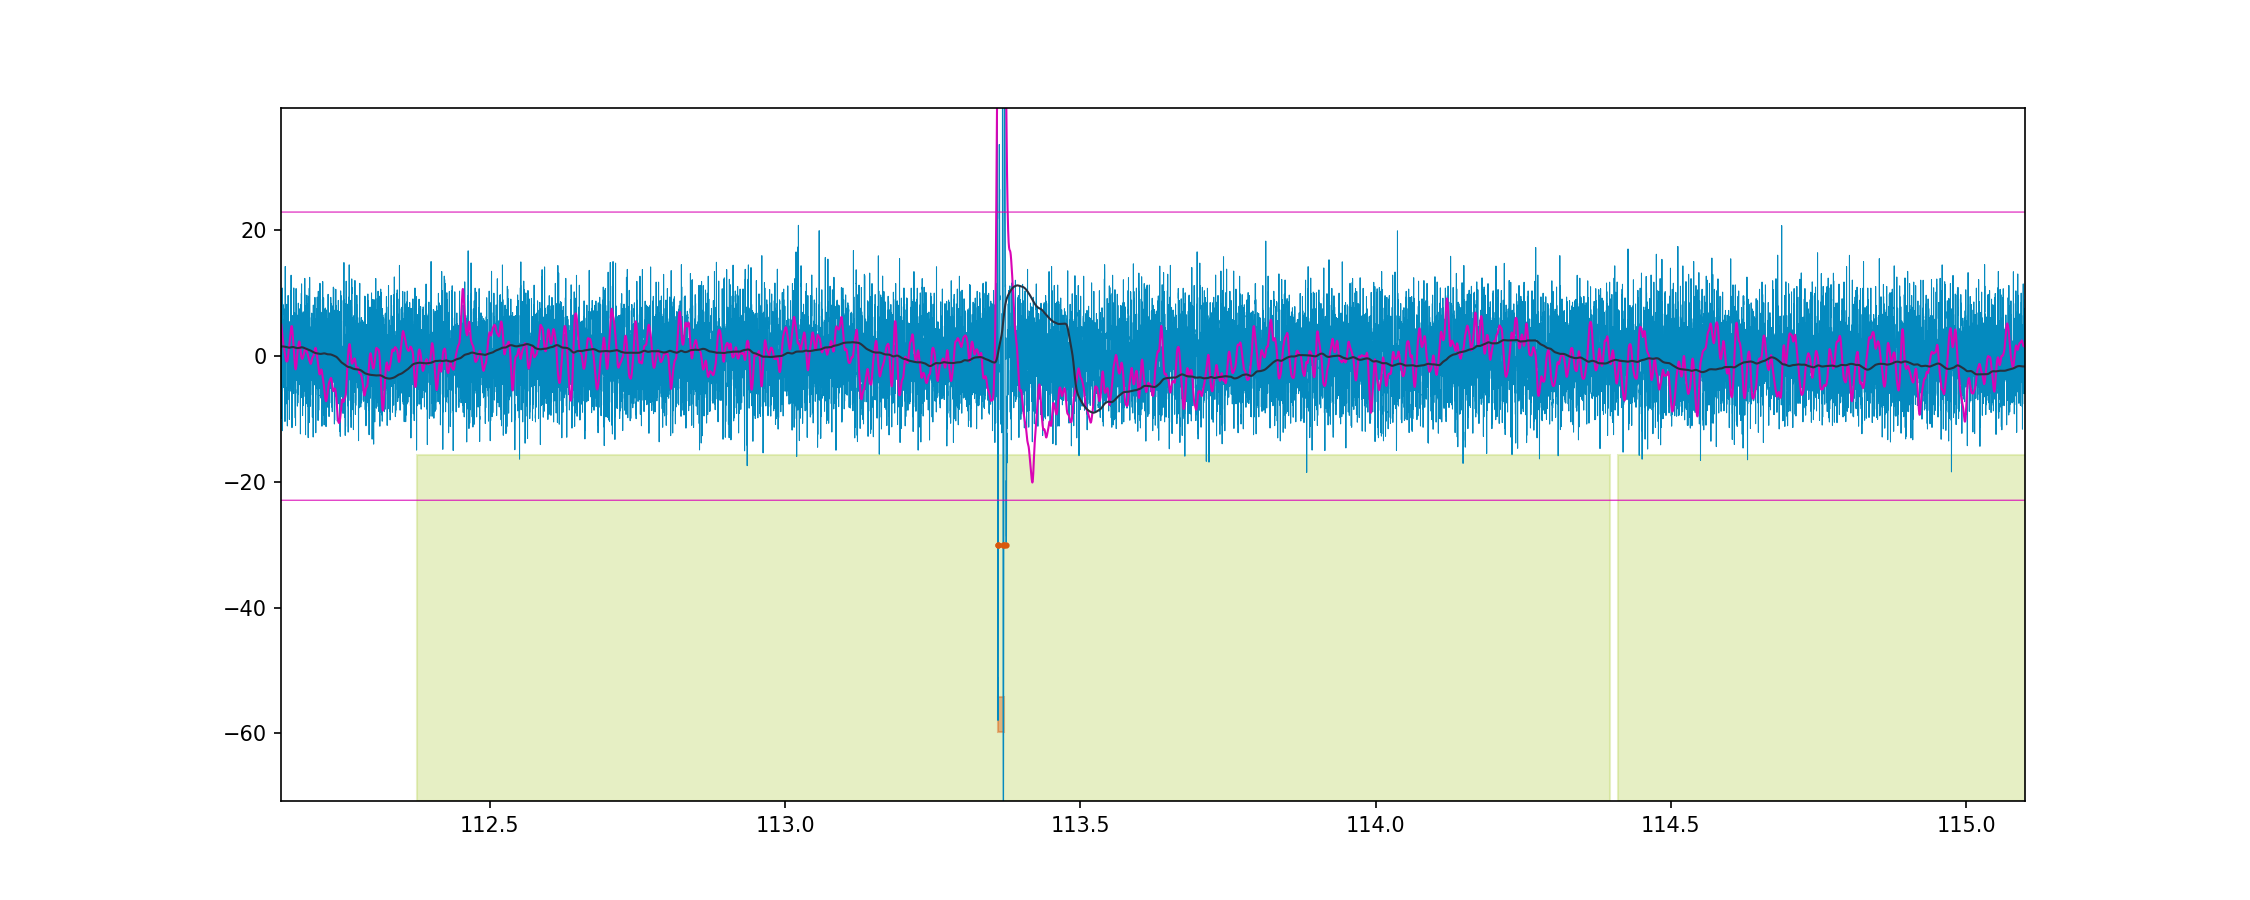

<ipython-input-168-a7d05fe0bb9f>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(spikes, [-30]*np.asarray(spikes).shape[0], 'ro', ms=2, c="#D9580D")


In [168]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))


ax.plot(time_in_sec[:second_cut], bandpass_sig, c = '#048ABF',  linewidth = 0.5)
ax.plot(time_in_sec[:second_cut], lowpass_sig, c = '#D904B5',  linewidth = 1)
ax.plot(spikes, [-30]*np.asarray(spikes).shape[0], 'ro', ms=2, c="#D9580D")
ax.plot(time_in_sec, cs_threshold_line, c = '#D904B5', linewidth = 0.5 )
ax.plot(time_in_sec, -cs_threshold_line, c = '#D904B5', linewidth = 0.5 )
#ax.plot(time_in_sec, -threshold_line, c = '#D904B5', linewidth = 0.5 )
ax.plot(time_in_sec[:second_cut], cs, c = '#263140',  linewidth = 1)


for i in cut_network_bursts_seconds:
    ax = plt.axvspan(i[0], i[1], .0, .5, color= '#C1D96C', alpha = 0.4)
for i in cs_down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in cs_up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)
for i in cut_channel_bursts_seconds:
    ax = plt.axvspan(i[0], i[1], .1, .15, color= '#D9580D', alpha = 0.4)

In [169]:
lfp_ups[channel_look]

[(62.59256, 62.663799999999995),
 (90.56564, 90.88163999999999),
 (106.7302, 107.01876)]

In [170]:
Infos_Anatomy = MAIN_RECORDING_DICTIONARY['Infos_Anatomy']


In [171]:
lfp_downs

{'G13': [(62.77824, 62.85068),
  (90.37467999999998, 90.59744),
  (106.61564, 106.81116),
  (113.49696, 113.57064)],
 'G12': [(62.71984, 62.90952),
  (77.35852, 77.431),
  (90.38883999999999, 90.59688),
  (106.61479999999999, 106.80936),
  (113.49204, 113.5846),
  (119.25291999999999, 119.35552)],
 'F16': [(16.40664, 16.48784),
  (60.18155999999999, 60.251839999999994),
  (62.752759999999995, 62.9428),
  (62.953, 63.06908),
  (90.37419999999999, 90.52036),
  (106.64208, 106.7578),
  (107.27248, 107.39156),
  (113.30463999999999, 113.35796),
  (113.49663999999999, 113.59456),
  (117.53864, 117.65151999999999),
  (119.24591999999998, 119.35231999999999)],
 'F15': [(90.35812, 90.52824), (106.62272, 106.77416)],
 'F14': [(62.74228, 62.88463999999999),
  (90.36392, 90.56848000000001),
  (106.61748, 106.79943999999999),
  (119.307, 119.37351999999998)],
 'F13': [(62.731519999999996, 63.01628),
  (90.38832, 90.59776),
  (106.63108, 106.80883999999999),
  (113.4934, 113.61207999999999),
  (119

In [193]:
def find_network_burst_components(network_bursts_seconds, 
                                  Bursts, spikedic_MAD, ups, up_amplitudes, downs, down_amplitudes):
    
    '''
    ______________________
    parameters
    
    network_bursts_seconds : list of tuples
        tuples are all filtered network bursts (i.e., the gaussian smoothed firing rate that
        crosses the mean of the smoothed firing rate)
        
        tuple(a, b) with a = burststart, b = burststop in seconds
        
    
    Bursts : dict
        key = channellabel
        value = list of tuples (a, b) with a = burststart, b = burststop in µseconds
        
    spikedic_MAD : dict
    
        key = channellabel
        value = list of spikes in ticks --> times tick and scale_factor_second_to_receive
            the spikes in seconds
            
    _______________________
    returns
        
    network_bursts_dictionary : dict
        key = tuple (a, b) with a = networkburststart, b = networkburststop in seconds
        
        value = tuple (a,b,c) with a=the number of single channel bursting channels,
                b = the number of active (i.e., spiking) channels, and c = array of all 
                single channel bursting channels
                
    relevant_relevant_channels : list
    
        list with all channels that are active at any network burst
        can be used to filter the original signal when extracting the LFP
    
    
    '''





    
    network_burts_dictionary = {}
    # relevant channels is basically all channels that burst at any time in one list
    relevant_channels = []

    for i in network_bursts_seconds:
        
        network_features_dic = {}
        
        network_key = str(i)
        burst_list = []
        bursting_channels = []
        active_channels = []
        
        # get all channels that burst while the network burst is going on
        total_number_burst_starts = 0
        total_number_burst_ends = 0
        for key in Bursts:   
            for b in Bursts[key]:
                # if either start or end of single channel burst is within the network burst
                burst_start = b[0]*1e-06
                burst_stop = b[1]*1e-06
                   
                    
                # every burst that starts and every burst that stops
                # is counted into the bursting channels and for the
                # total number of bursts
               
                if i[0] <= burst_start <= i[1]:
                    bursting_channels.append(key)
                    relevant_channels.append(key)
                    total_number_burst_starts +=1
                    
                    
                if i[0] <= burst_stop <= i[1]:
                    bursting_channels.append(key)
                    relevant_channels.append(key)
                    total_number_burst_ends +=1
        
        # all channels that have a spike
        spikecount = 0
        for key in spikedic_MAD:
            for s in spikedic_MAD[key]:
                s = s*tick*1e-06
                if i[0] <= s <= i[1]:
                    spikecount += 1
                    active_channels.append(key)
                    
                    
        lfp_up_list = []            
        for key in ups:
            for up in ups[key]:
                up_start = up[0]
                up_stop = up[1]

                if (i[0] <= up_start <= i[1]) or (i[0] <= up_stop <= i[1]):
                    lfp_up_list.append(key)
                    
        lfp_up_amplitudes = []
        for key in up_amplitudes:
            amps = up_amplitudes[key]
            for amp in amps:
                lfp_up_amplitudes.append(amp)
            
        average_up = np.mean(lfp_up_amplitudes)            
        
        
        lfp_down_list = []            
        for key in downs:
            for down in downs[key]:
                down_start = down[0]
                down_stop = down[1]

                if (i[0] <= down_start <= i[1]) or (i[0] <= down_stop <= i[1]):
                    lfp_down_list.append(key)
                    
        lfp_down_amplitudes = []
        for key in down_amplitudes:
            amps = down_amplitudes[key]
            for amp in amps:
                lfp_down_amplitudes.append(amp)
            
        average_down = np.mean(lfp_down_amplitudes)
        
        # add features to the dictionary
        # bursting channels
        bursting_channels = np.unique(bursting_channels)
        network_features_dic['bursting_channels'] = bursting_channels
        
        # number of bursting channels
        n_bursting_channels = len(bursting_channels)
        network_features_dic['number_of_bursting_channels'] = n_bursting_channels
        
        # number of bursting channels
        network_features_dic['number_burst_starts'] = total_number_burst_starts
        network_features_dic['number_burst_ends'] = total_number_burst_starts
        
        #active channels
        active_channels = np.unique(active_channels)
        network_features_dic['active_channels'] = active_channels
        
        #number of active channels
        n_active_channels = len(active_channels)
        network_features_dic['number_of_active_channels'] = n_active_channels
        
        #total number of spikes 
        network_features_dic['number_of_spikes'] = spikecount
        
        #up lfps:
        network_features_dic['channels_lfp_up'] = np.unique(lfp_up_list)
        network_features_dic['mean_up_lfp_amplitude'] = average_up
        
        #down lfps:
        network_features_dic['channels_lfp_down'] = np.unique(lfp_down_list)
        network_features_dic['mean_down_lfp_amplitude'] = average_down
        
        
        
        
        network_bursts_dictionary[network_key] = (network_features_dic)
    
    return network_bursts_dictionary, relevant_channels
        

in die obige Funktion muss folgendes rein, bzw. es muss folgenden gemacht werden:
- jeder Netzwerkburst wird zum key
- als value wird ein dictionary mit folgenden Werten:
- anzahl spikes
- anzahl bursts
- anzahl active channels
- anzahl bursting channels
- anzahl lfp ups
- mean amplitude lfp ups
- anzahl lfp downs
- mean amplitude lfp downs
- length der lfp ups and downs
- spannend auch wieviele der spikes sind burst spikes und wieviel single spikes

###### im DF dazu: 
- anzahl der beteiligten channels pro layer
- ggf. auch prozentual


###### im Anschluss
für jeden Netzworkburst eine Heatmap mit der Ausbreitung
- das alles muss pro recording für die 120 sekunden Untereinheit gemacht werden
- vorteil ist, das geht alles in einen dataframe, ist also nicht schlimm, dass es ggf. nacheinander kommt.


###### ich kann nicht mehr
im dataframe werden damit auch erstmal völlig wertfrei alle quatsch network bursts (also nur 1 channel oder ähnliches) aufgenommen. das ist nicht schlimm, da im Anschluss alles gefiltert werden kann. 

###### Idee für später: 
-das Burst verhalten eines Channels zu charakterisieren (periodisch, sporadisch, anzahl units, layer)

In [194]:
trial, asb = find_network_burst_components(network_bursts_seconds, 
                                  Bursts, spikedic_MAD, lfp_ups, lfp_amplit_ups, lfp_downs, lfp_amplit_downs)

In [195]:
trial

{'(0.7632, 1.7830399568106312)': {'bursting_channels': array(['H3', 'J2', 'J3', 'K2', 'L1', 'L2'], dtype='<U2'),
  'number_of_bursting_channels': 6,
  'number_burst_starts': 6,
  'number_burst_ends': 6,
  'active_channels': array(['C2', 'E3', 'F2', 'F3', 'G1', 'G2', 'H1', 'H2', 'H3', 'J2', 'J3',
         'K2', 'K3', 'K4', 'L1', 'L2'], dtype='<U2'),
  'number_of_active_channels': 16,
  'number_of_spikes': 49,
  'channels_lfp_up': array(['D12', 'D2', 'F1', 'G16', 'H1', 'H3', 'H6', 'J2', 'K9', 'L2', 'L3',
         'N2', 'N6', 'O7', 'P14', 'R12', 'R3'], dtype='<U3'),
  'mean_up_lfp_amplitude': 134.81564096040537,
  'channels_lfp_down': array(['B10', 'C11', 'C2', 'D2', 'D6', 'F6', 'F8', 'G15', 'G2', 'G3',
         'G6', 'H2', 'H3', 'J3', 'K2', 'K3', 'K5', 'M4', 'M5', 'M6', 'O10',
         'R12'], dtype='<U3'),
  'mean_down_lfp_amplitude': -161.13956197953246},
 '(4.198971504983389, 5.520802905315615)': {'bursting_channels': array(['J2', 'K2', 'L2'], dtype='<U2'),
  'number_of_bursting_chann

In [187]:
lfp_down_amplitudes = []
for key in lfp_amplit_downs:
    amps = lfp_amplit_downs[key]
    for amp in amps:
        lfp_down_amplitudes.append(amp)

average_down = np.mean(lfp_down_amplitudes)

In [189]:
average_down


-161.13956197953246